In [63]:
# Necessary imports
import pandas as pd
import numpy as np
import pandas as pd
import datetime as dt
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import os
import re
import requests
from sklearn import linear_model

#ML libraries
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE


In [36]:
def MAPE(predicted, actual,log2_input=True): 
    if log2_input:
        predicted = 2**predicted
        actual = 2**actual
    error = actual-predicted
    abs_error = np.abs(error)
    abs_perc_error = (abs_error/actual)*100
    print('--------------------------------')
    print('Testing Model Absolute Percentage error (APE)')
    print(f'Median APE (MAPE) = {abs_perc_error.median():.2f}%')
    print(f'Mean APE  = {abs_perc_error.mean():.2f} %')
    print(f"25th percentile APE = {abs_perc_error.quantile(q=0.25):.2f} %")
    print(f"75th percentile APE = {abs_perc_error.quantile(q=0.75):.2f} %")


In [37]:
# defince a constant for the sol base unit of 1000000000
SOL_BASE = 1000000000


## Import Traits/Rarity Data 

In [38]:
all_dirs = next(os.walk('data'))[1]
collections = []
for i in all_dirs:
    files =  os.listdir(f'data/{i}/')
    correct_files = all(x in files for x in ['transactions.csv','rarity.csv' ])
    if correct_files:
        collections.append(i)
     

#drop solana_monkey_business
collections.remove('solana_monkey_business')

collections

['trippin_ape_tribe', 'okay_bears', 'primates', 'justape']

In [39]:

trait_dfs ={}
trait_list ={}
slug = {'justape':'ape', 'okay_bears':'okay_bears',
        'primates':'primates','trippin_ape_tribe':'trippin_ape_tribe'}
for i in collections:
    df = pd.read_csv(f"data/{i}/rarity.csv")
    df = df.replace('None', np.nan)
    rarity_cols = df.filter(regex='_rarity',axis=1).columns
    collection_trait_list=[]
    for col in rarity_cols:
        prefix = re.sub("_rarity", "", col)
        if prefix in df.columns:
            collection_trait_list.append(prefix)

    df['trait_n'] = df[collection_trait_list].count(axis=1)

    #get mint_id 
    
    url = f'https://moonrank.app/mints/{slug[i]}?after=0&seen={df.shape[0]}&complete=true'
    response = requests.request("GET", url).json()
    response = response['mints']
    mint_id = pd.DataFrame.from_records(response)[['mint','name']]
    df = df.merge(mint_id, on='name')

    trait_dfs[i]=df
    trait_list[i] = collection_trait_list



trait_dfs[collections[2]].head()


,Unnamed: 0,name,Background,Body,Clothing,Eyes,Head,Mouth,Background_rarity,Body_rarity,Clothing_rarity,Eyes_rarity,Head_rarity,Mouth_rarity,rarity_rank,overall_rarity,min_rarity,mean_rarity,trait_n,mint
0,0,Primate #1997,Blue,Naked,Hazard Suit,Wide Eyed,Ventilation Mask,Content,10.37,19.21,0.01,4.70,0.01,18.05,1,1.689979e-12,0.01,8.725000,6,5ZmMDaqNUCgHi2aRQdki5xnf8jFyadkVow7RibfhvgiU
1,1,Primate #1154,Lilac,Scarred,Winter Jacket,Eye Patch,Birdman,Banana,10.00,9.13,0.82,3.02,0.42,2.82,2,2.677873e-10,0.42,4.368333,6,D1c78VYbE7d8JAvBzqtBCG3smwdTDnmbzwq46Kbf79T1
2,2,Primate #7631,Yellow,Test Dummy,Space Suit,Eyeball,Beanie,Banana,9.83,4.17,0.51,2.85,1.87,2.82,3,3.141921e-10,0.51,3.675000,6,2JzEo7NZTrM52b5AT4fTupUp1ZckBWCFuaWPDi9aS2Lm
3,3,Primate #2088,Yellow,Intestines,Cyber Zip-Up,Thief,Tactical Helmet,Cigarette,9.83,4.23,0.89,1.97,0.91,5.09,4,3.376831e-10,0.89,3.820000,6,4vzX37D38pX5n6FcTJgRPXFAi37ZS8VFhWj19y8DTHav
4,4,Primate #628,Orange,Test Dummy,Alchemist Jacket,Meth Scientist,Skate Helmet,Bubble Gum,9.85,4.17,0.98,1.83,1.00,4.80,5,3.535824e-10,0.98,3.771667,6,9XmUTtXjcmEHbZPWKrzTW6u2qxLg4VqezF2DQ4iZ35jM


In [40]:
### get all sales
sales =pd.DataFrame()
cols_to_keep =['tokenMint','collection','blockTime','price']
for i in collections:
    df = pd.read_csv(f"data/{i}/transactions.csv")
    df = df[cols_to_keep].drop_duplicates()
    df['collection'] = i
    print(f"Found {df.shape[0]} sales for {i}")
    first_sale = df.blockTime.min()
    df['collection_age'] = df["blockTime"] - first_sale

    sales = sales.append(df)


#create timeDiff (easier for ML to interprut than date)
sales['timeDiff'] = sales["blockTime"] -  sales["blockTime"].min()
#convert time from epoch to datetime
sales["blockTime"] = pd.to_datetime(sales["blockTime"], unit="s")
#add a log2 price
sales['log2_price'] = np.log2(sales.price)


#extract the date of sale
sales['day']=sales.blockTime.dt.date
sales.head()

Found 8743 sales for trippin_ape_tribe
Found 18020 sales for okay_bears
Found 18507 sales for primates
Found 14392 sales for justape


,tokenMint,collection,blockTime,price,collection_age,timeDiff,log2_price,day
0,ExuwwKn3DkSXyHgdAWhgHNwirU6hcoeiEvWbMYexPSC1,trippin_ape_tribe,2022-07-04 14:11:41,21.00,3535981,5939972,4.392317,2022-07-04
1,C7nMtUSEr8KRc1HXJjPMKeTa6SVCskoJWra8zu3akgi3,trippin_ape_tribe,2022-07-04 14:04:09,17.00,3535529,5939520,4.087463,2022-07-04
2,8RTv26Ss5pQXtZbShpx4jteX8YkSvEqF66HzmtNNo9HC,trippin_ape_tribe,2022-07-04 13:43:55,20.00,3534315,5938306,4.321928,2022-07-04
3,CSb33H9FpthTmn8LpJQa2Tk41DzYgVn3mMsrMnAMzzM1,trippin_ape_tribe,2022-07-04 11:20:45,21.00,3525725,5929716,4.392317,2022-07-04
4,5PamEKs3trrkvSZLigx1a7Yt4Rqx2iY9VgfGokotr1dk,trippin_ape_tribe,2022-07-04 09:56:37,18.66,3520677,5924668,4.221877,2022-07-04


In [41]:
#calculate daily median price by collection
daily_SOL_median = pd.DataFrame(sales.groupby(['day','collection'])['price'].median())
daily_SOL_median= daily_SOL_median.reset_index().rename(columns={'price':'daily_median_price'})

In [43]:
## calculate daily floor price (5th percentile of sales)
daily_floor = sales.groupby(['day','collection'])['price'].quantile(q=0.05)
daily_floor = pd.DataFrame(daily_floor).reset_index().rename(columns={'price':'daily_floor'})
daily_floor.day.max()

datetime.date(2022, 7, 4)

In [44]:
#merge all together
sales = sales.merge(daily_SOL_median, on=['day','collection'],how='inner').merge(daily_floor,on=['day','collection'],how='inner')
sales.head()
#daily_SOL_median

,tokenMint,collection,blockTime,price,collection_age,timeDiff,log2_price,day,daily_median_price,daily_floor
0,ExuwwKn3DkSXyHgdAWhgHNwirU6hcoeiEvWbMYexPSC1,trippin_ape_tribe,2022-07-04 14:11:41,21.00,3535981,5939972,4.392317,2022-07-04,19.02,17.66
1,C7nMtUSEr8KRc1HXJjPMKeTa6SVCskoJWra8zu3akgi3,trippin_ape_tribe,2022-07-04 14:04:09,17.00,3535529,5939520,4.087463,2022-07-04,19.02,17.66
2,8RTv26Ss5pQXtZbShpx4jteX8YkSvEqF66HzmtNNo9HC,trippin_ape_tribe,2022-07-04 13:43:55,20.00,3534315,5938306,4.321928,2022-07-04,19.02,17.66
3,CSb33H9FpthTmn8LpJQa2Tk41DzYgVn3mMsrMnAMzzM1,trippin_ape_tribe,2022-07-04 11:20:45,21.00,3525725,5929716,4.392317,2022-07-04,19.02,17.66
4,5PamEKs3trrkvSZLigx1a7Yt4Rqx2iY9VgfGokotr1dk,trippin_ape_tribe,2022-07-04 09:56:37,18.66,3520677,5924668,4.221877,2022-07-04,19.02,17.66


In [45]:
SOL_USD = pd.read_csv('data/sol_to_usd_data.csv')
SOL_USD= SOL_USD.rename(columns={'open':'SOL_USD', 'time':'hour'})
SOL_USD['hour']= pd.to_datetime(SOL_USD.hour)
sales['hour']=sales.blockTime.dt.floor(freq='h')

sales = sales.merge(SOL_USD[['hour','SOL_USD']], on='hour',how='inner')
sales.head()


,tokenMint,collection,blockTime,price,collection_age,timeDiff,log2_price,day,daily_median_price,daily_floor,hour,SOL_USD
0,ExuwwKn3DkSXyHgdAWhgHNwirU6hcoeiEvWbMYexPSC1,trippin_ape_tribe,2022-07-04 14:11:41,21.0,3535981,5939972,4.392317,2022-07-04,19.02,17.6600,2022-07-04 14:00:00,33.76
1,C7nMtUSEr8KRc1HXJjPMKeTa6SVCskoJWra8zu3akgi3,trippin_ape_tribe,2022-07-04 14:04:09,17.0,3535529,5939520,4.087463,2022-07-04,19.02,17.6600,2022-07-04 14:00:00,33.76
2,8ULtLMxvguKg36jeAbJT7evyRnZuPekAFwwGsMyL9GNV,primates,2022-07-04 14:52:16,18.2,1715651,5942407,4.185867,2022-07-04,17.50,15.6315,2022-07-04 14:00:00,33.76
3,3ErnV3zLeYQkr18GVMrntrNJyRkvwLHTrRLbBmd7r1XU,primates,2022-07-04 14:48:41,18.0,1715436,5942192,4.169925,2022-07-04,17.50,15.6315,2022-07-04 14:00:00,33.76
4,ANnRaHZSwTRVWri4EW4EZvfeA3kbftxaWMVKs1TGWKj,primates,2022-07-04 14:43:54,17.8,1715149,5941905,4.153805,2022-07-04,17.50,15.6315,2022-07-04 14:00:00,33.76


/Users/sampink/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

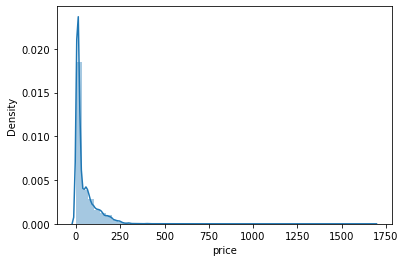

In [18]:
sns.distplot( a=sales.price, hist=True, kde=True, rug=False )

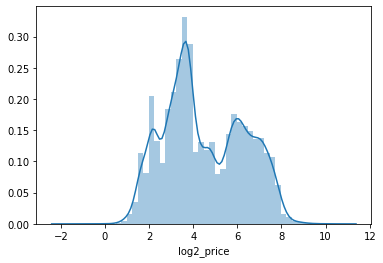

In [240]:
sns.distplot( a=sales.log2_price, hist=True, kde=True, rug=False )

In [46]:
rarity_cols = ['mint','Background_rarity', 'Clothes_rarity', 'Eyes_rarity',
       'Eyewear_rarity', 'Fur_rarity', 'Hat_rarity', 'Mouth_rarity',
       'rarity_rank', 'overall_rarity', 'min_rarity', 'mean_rarity',
       'trait_n']



In [47]:
collection_n_traits = [len(trait_list[i]) for i in collections]

final_rarity_cols = [f"trait_{i}_rarity" for i in np.arange(0, np.min(collection_n_traits))]
final_rarity_cols

['trait_0_rarity',
 'trait_1_rarity',
 'trait_2_rarity',
 'trait_3_rarity',
 'trait_4_rarity',
 'trait_5_rarity']

In [48]:
cat_vars = ['trait_n']
num_cols = ['collection_age','timeDiff','rarity_rank',
             'overall_rarity', 'min_rarity', 'mean_rarity',
             'daily_median_price', 'daily_floor', 'SOL_USD']+final_rarity_cols

training_cols = cat_vars+num_cols

## Combine traits/rarities for all collections into a single df 

- However, traits not comparable across collections... 
- Rarities, however are comparable 
- But we can include single trait rarities, but ordering them buy their effect on price
- For example trait_0_rarity will be the rarity of the trait within the collection which has the highest impact on price 
- Impact on price is defined through a multiple linear regression model

###

In [49]:
# join the sales and rarity dataframes on name
sales_rarity_all = pd.DataFrame()
for i in collections:
    rarity_cols = [s + '_rarity' for s in trait_list[i]]


    sales_rarity = sales.merge(trait_dfs[i],left_on='tokenMint', right_on="mint")
    rarity_price_corr_df = pd.DataFrame()
    y = sales_rarity.log2_price
    for trait_rarity in rarity_cols:
        X = sales_rarity[['daily_median_price',trait_rarity]]
        lm = linear_model.LinearRegression()
        lm.fit(X, y)
        rarity_coeff = np.abs(lm.coef_[1])
        rarity_price_corr_df = rarity_price_corr_df.append({'trait':trait_rarity, 'abs_coeff':rarity_coeff},True)

    rarity_price_corr_df = rarity_price_corr_df.sort_values('abs_coeff',ascending=False).reset_index(drop=True)
    rarity_price_corr_df = rarity_price_corr_df.head(np.min(collection_n_traits))


    for index, row in rarity_price_corr_df.iterrows():
        new_name = f"trait_{index}_rarity"
        sales_rarity = sales_rarity.rename(columns={row.trait:new_name})
        trait_dfs[i] = trait_dfs[i].rename(columns={row.trait:new_name})

    sales_rarity= sales_rarity[training_cols+['log2_price']]  

    sales_rarity_all = sales_rarity_all.append(sales_rarity)

sales_rarity_all.shape

(59662, 17)

In [50]:
trait_dfs[i]

,Unnamed: 0,name,Accessory,Background,Body,Eyes,Fur,Head,Mouth,trait_5_rarity,...,trait_3_rarity,trait_1_rarity,Head_rarity,trait_4_rarity,rarity_rank,overall_rarity,min_rarity,mean_rarity,trait_n,mint
0,0,Ape #6194,Hoops,Wheat,Hoodie Hooded,Relaxed,Magma,NaN,Cheeky,2.28,...,5.81,2.07,8.01,6.91,1,3.375563e-11,0.23,4.997143,6,8f82DYXm2AsXEPcPG1uti4nMfm4GwGEwNz7eyNHBMD92
1,1,Ape #4692,Bar,Wheat,Hoodie Hooded,Blank Stare,Cosmic,NaN,Disgusted,3.57,...,6.04,3.55,8.01,6.64,2,9.054999e-11,0.23,5.387143,6,GqT8gsZasRkjBHCfHTLpML3hEBV2xFteYdCCWFeW2KGN
2,2,Ape #1973,Diamond Studs,Sky,Hoodie Hooded,Mmmmkay,Cosmic,NaN,Grin,3.48,...,5.94,3.55,8.01,6.78,3,9.248584e-11,0.23,5.440000,6,En6pNYzkmCAwpeNtNYeanZAxC1vUmPbJbtiTGn4nimeD
3,3,Ape #2393,Hoops,Rose,Bearish,Relaxed,Amphibian,Ivy Cap,Confused,2.28,...,5.81,3.15,5.77,6.88,4,1.154400e-10,0.69,4.954286,7,QqpjuafdQ7eFZmnTtADvDUoY5TuKPZqyxtjm5kFZuiV
4,4,Ape #1490,Hoops,Rose,Shirt and Vest,Bewildered,Aquatic,Beret,Loathing,2.28,...,5.65,1.95,2.18,6.31,5,1.211029e-10,1.95,4.562857,7,2ZdNFuuPfZAnm3cwzbKLESGmW5LMyaUzdRCdruPe4wDH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,Ape #4267,NaN,Snow,Hoodie,Neutral,Silverback,NaN,Smile,75.97,...,11.98,12.62,8.01,13.80,9996,7.646371e-07,5.87,19.787143,5,92MUJjafmSQmvSvvtDZFatUbbFpiNe2UctHK3cuEUXjv
9996,9996,Ape #5305,NaN,Wheat,Adventurer in Flannel,Neutral,Coffee,Winter Beanie,Smile,75.97,...,11.98,19.44,9.93,13.80,9997,7.713401e-07,3.29,20.582857,6,3LoHYHgc3UoRihaKuct3wpv2V5y72AVZY3X5rFJ5Ffuk
9997,9997,Ape #6227,NaN,Rose,Hoodie,Neutral,Coffee,Trilby,Smile,75.97,...,11.98,19.44,5.34,13.80,9998,7.729920e-07,5.34,20.357143,6,DpG6q3AZZjbVRJ8cKFSbC6miAh8pbmJxHeADcchsA8Wk
9998,9998,Ape #5150,NaN,Forest,Short Sleeve Buttondown,Neutral,Coffee,Backwards Flat Cap,Smile,75.97,...,11.98,19.44,6.81,13.80,9999,8.285643e-07,5.18,20.400000,6,AGK4LyC6SvfZP6pkN22qJEbEanLotquwoy5EuVPTgZv8


In [51]:
sales_rarity_all.columns



Index(['trait_n', 'collection_age', 'timeDiff', 'rarity_rank',
       'overall_rarity', 'min_rarity', 'mean_rarity', 'daily_median_price',
       'daily_floor', 'SOL_USD', 'trait_0_rarity', 'trait_1_rarity',
       'trait_2_rarity', 'trait_3_rarity', 'trait_4_rarity', 'trait_5_rarity',
       'log2_price'],
      dtype='object')

In [52]:
#define target varaible as price in solana 

y = sales_rarity_all.log2_price
preprocess_df = sales_rarity_all.copy()
preprocess_df.drop(columns=['log2_price'], inplace=True)


In [53]:
preprocess_df.head(4)


,trait_n,collection_age,timeDiff,rarity_rank,overall_rarity,min_rarity,mean_rarity,daily_median_price,daily_floor,SOL_USD,trait_0_rarity,trait_1_rarity,trait_2_rarity,trait_3_rarity,trait_4_rarity,trait_5_rarity
0,5,3535981,5939972,1206,1.477922e-09,0.94,4.416667,19.02,17.660,33.76,2.74,2.81,7.99,0.94,2.76,9.26
1,5,1223648,3627639,1206,1.477922e-09,0.94,4.416667,19.89,17.200,39.50,2.74,2.81,7.99,0.94,2.76,9.26
2,6,3535529,5939520,9810,1.702801e-07,4.46,7.801667,19.02,17.660,33.76,4.46,5.61,10.78,7.17,9.86,8.93
3,6,57928,2461919,9810,1.702801e-07,4.46,7.801667,58.45,46.525,48.80,4.46,5.61,10.78,7.17,9.86,8.93


In [54]:
#create binary dummary varaib
preprocess_df = pd.get_dummies(preprocess_df, columns=cat_vars   )
preprocess_df.shape

(59662, 19)

In [55]:
#scale numeric variables
ss = StandardScaler()
ss= ss.fit(preprocess_df[num_cols])
preprocess_df[num_cols] = ss.transform(preprocess_df[num_cols])


In [56]:
preprocess_df.head(4)

,collection_age,timeDiff,rarity_rank,overall_rarity,min_rarity,mean_rarity,daily_median_price,daily_floor,SOL_USD,trait_0_rarity,trait_1_rarity,trait_2_rarity,trait_3_rarity,trait_4_rarity,trait_5_rarity,trait_n_4,trait_n_5,trait_n_6,trait_n_7
0,3.306928,1.596243,-1.438241,-0.174668,-1.074634,-1.167305,-0.415063,-0.321965,-0.659947,-0.465267,-1.519695,0.129989,-1.166525,-0.817101,-0.457079,0,1,0,0
1,0.723798,0.289962,-1.438241,-0.174668,-1.074634,-1.167305,-0.397382,-0.332843,-0.425875,-0.465267,-1.519695,0.129989,-1.166525,-0.817101,-0.457079,0,1,0,0
2,3.306423,1.595987,1.574473,0.097272,2.094318,-0.573760,-0.415063,-0.321965,-0.659947,-0.029370,-0.959946,0.624514,0.000632,0.417983,-0.469245,0,0,1,0
3,-0.578439,-0.368575,1.574473,0.097272,2.094318,-0.573760,0.386275,0.360599,-0.046629,-0.029370,-0.959946,0.624514,0.000632,0.417983,-0.469245,0,0,1,0


In [57]:
# create train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    preprocess_df, y, test_size=0.15, random_state=42
)


print(f"train set has {x_train.shape[0]} datapoints and test set has {x_test.shape[0]} datapoints")


train set has 50712 datapoints and test set has 8950 datapoints


In [58]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,max_depth=10
)
#fit the model
xgb_model.fit(x_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1500,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [59]:
#prediction on test set
xgb_ypred = xgb_model.predict(x_test)
MAPE(predicted=xgb_ypred, actual=y_test, log2_input=True)

--------------------------------
Testing Model Absolute Percentage error (APE)
Median APE (MAPE) = 4.14%
Mean APE  = 7.49 %
25th percentile APE = 1.80 %
75th percentile APE = 8.68 %


In [60]:
#calculate MSE
xgb_mse = MSE(2**y_test, 2**xgb_ypred)
print(f"XGBoost Mean-squared Error = {xgb_mse} SOL")

XGBoost Mean-squared Error = 120.00426567191117 SOL


In [61]:
feat_imp = xgb_model.feature_importances_
sorted_idx = feat_imp.argsort()[::-1]
sorted_idx2 = sorted_idx[2:len(sorted_idx)]


feat_imp[sorted_idx]

array([9.5109999e-01, 2.2549491e-02, 6.5968642e-03, 4.6362020e-03,
       3.1920718e-03, 2.0119022e-03, 1.5138286e-03, 1.3260030e-03,
       1.2168725e-03, 1.1691417e-03, 8.6739950e-04, 7.8257220e-04,
       7.1428454e-04, 4.8914645e-04, 4.8865896e-04, 4.4906815e-04,
       3.3688001e-04, 2.9387846e-04, 2.6569125e-04], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

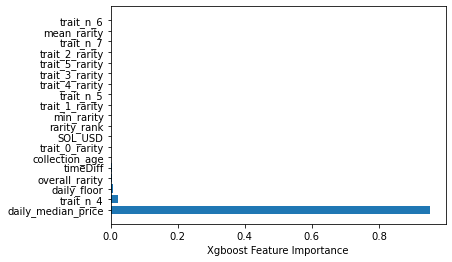

In [64]:
plt.barh(x_train.columns[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Text(0.5, 0, 'Xgboost Feature Importance')

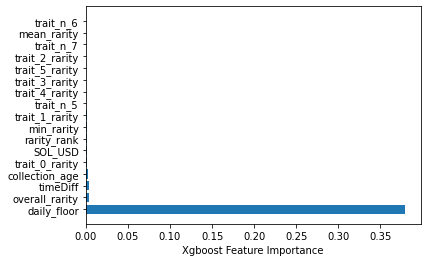

In [85]:
plt.barh(x_train.columns[sorted_idx2], feat_imp[sorted_idx2])
plt.xlabel("Xgboost Feature Importance")

In [84]:
fig = px.scatter(x=2**xgb_ypred, y=2**y_test, trendline="ols",opacity =0.3, 
        labels={
                     "x": "Predicted Sale Price (SOL)",
                     "y": "Actual Sale Price (SOL)"
                 })
fig.show()

In [79]:
for i in collections:
    x_predict = trait_dfs[i].copy()
    collection_sales = sales[sales.collection ==i]
    x_predict = pd.get_dummies(x_predict, columns =cat_vars)

    latest_sale = collection_sales[collection_sales.timeDiff ==collection_sales.timeDiff.max()].reset_index(drop=True)

    cols2add = ['collection_age', 'timeDiff','daily_median_price', 'daily_floor','SOL_USD']
    for trait in cols2add:
        x_predict[trait] = latest_sale[trait][0]


    #get trained columns
    trained_vars = x_train.columns.to_list()

    if 'trait_n_7' not in x_predict.columns:
        x_predict['trait_n_7']=0

    x_predict = x_predict[['name']+trained_vars]
    x_predict[num_cols] = ss.transform(x_predict[num_cols])

    prediction = xg_grid.predict(x_predict[trained_vars])

    x_predict['pred_SOL'] = 2**prediction
    x_predict.head()

    pred_price = trait_dfs[i].merge( x_predict[['name','pred_SOL']],on='name').sort_values('pred_SOL',ascending=False)
    pred_price.to_csv(f"data/{i}/predicted.csv")


In [71]:
xgb2 = xgb.XGBRegressor(nthread=-1,seed=42,objective ="reg:squarederror" )

xg_grid = GridSearchCV(xgb2, 
                       param_grid={'n_estimators':[1500],
                                    'max_depth': [2,6,8],
                                    'subsample':[0.2,0.5,0.7],
                                    'colsample_bytree':[0.7,0.9],
                                    'eta':[0.5],
                                    'learning_rate':[0.1,0.3,0.4]},
                        cv=10, n_jobs=-1,scoring='neg_mean_absolute_error')



#fit the model
xg_grid.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_ca...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, nthread=-1,
                                    num_pa

In [73]:
xg_grid.best_params_

{'colsample_bytree': 0.9,
 'eta': 0.5,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 1500,
 'subsample': 0.7}

In [74]:
xg_grid.best_score_

-0.09991653214642035

In [83]:

feat_imp = xg_grid.best_estimator_.feature_importances_
sorted_idx = feat_imp.argsort()[::-1]

plt.barh(x_train[cols2fit].columns[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

NameError: name 'cols2fit' is not defined

In [81]:
fig = px.scatter(x=xgb2_ypred, y=y_test)
fig.show()

NameError: name 'xgb2_ypred' is not defined

In [82]:
print(f"max = {y.max()}, mean = {y.min()}, mean = {y.mean()}, median = {y.median()}")

max = 10.709945380232497, mean = -6.643856189774724, mean = 4.418719070649179, median = 4.169925001442312


In [86]:
#prediction on test set
xgb_ypred = xg_grid.predict(x_test)
#xgb_ypred = 2**xgb_ypred_log2
MAPE(predicted=xgb_ypred, actual=y_test)

--------------------------------
Testing Model Absolute Percentage error (APE)
Median APE (MAPE) = 4.02%
Mean APE  = 7.00 %
25th percentile APE = 1.77 %
75th percentile APE = 7.96 %


In [290]:
predict_SOL.predicted_SOL.median()
predict_SOL.to_csv('data/okay_bear/okay_bears_pred.csv')